# Explore lexicon in Vatican publications

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
from vatican.vatican.database import VaticanMongoDb

In [3]:
db = VaticanMongoDb(db_name='vatican', collection='tokens')

In [4]:
docs = db.documents

In [5]:
len(docs)

196

In [6]:
[(x, y) for x, y in docs if x == 'Paul VI']

[('Paul VI', 'Mense Maio'),
 ('Paul VI', 'Humanae Vitae'),
 ('Paul VI', 'Populorum'),
 ('Paul VI', 'Ecclesiam'),
 ('Paul VI', 'Sacerdotalis'),
 ('Paul VI', 'Mysterium'),
 ('Paul VI', 'Christi Matri')]

## Term Frequency (TF)

$$
tf(d, t) = \frac{count(d, t)}{\max\limits_{i}^{n} count(d, t_i)}
$$

In [7]:
pope, document = 'Paul VI', 'Humanae Vitae'
tf_count = db.document_term_count(pope, document)
tf = tf_count / tf_count.max()

In [8]:
tf_count.sort_values(ascending=False).head(10)

,         444
il        406
di il     290
e         220
di        199
.         193
a il      135
essere    127
che       116
uno        80
dtype: int64

In [9]:
tf.sort_values(ascending=False).head(10)

,         1.000000
il        0.914414
di il     0.653153
e         0.495495
di        0.448198
.         0.434685
a il      0.304054
essere    0.286036
che       0.261261
uno       0.180180
dtype: float64

## Document Frequency and Inverse Document Frequency (IDF)

$$
df(t) = \mid\{ d_i : t \in d_i \}\mid
$$

$$
idf(t) = \log \frac{N}{df(t)}
$$

In [10]:
df = db.sentence_df()
s_count = db.sentence_count

In [11]:
s_count

69512

In [12]:
df.sort_values(ascending=False).head(10)

.         50205
,         45529
il        41112
e         31473
di il     29058
di        27873
essere    23354
che       22799
a il      16575
a         15565
dtype: int64

In [13]:
idf = np.log(s_count / df)

In [14]:
idf.sort_values(ascending=False).head(10)

deducant        11.149255
umanità».[79    11.149255
X(24            11.149255
usare le        11.149255
vastamente      11.149255
Mandatene       11.149255
sorvolare       11.149255
soggiacque      11.149255
HUMANAE         11.149255
dialogo.[33     11.149255
dtype: float64

## TfIdf

$$
tfidf(d, t) = tf(d, t) \cdot idf(t)
$$

In [15]:
def tfidf(tf, idf, min_idf=0):
    tfidf_data = {}
    for t, tf_x in tf.items():
        idf_w = idf[t]
        if idf_w >= min_idf:
            tfidf_data[t] = tf_x * idf_w 
    return pd.Series(tfidf_data)

In [16]:
tfidf_hv = tfidf(tf, idf, min_idf=4)

In [17]:
tfidf_hv.sort_values(ascending=False).head(10)

coniugale      0.473365
sposo          0.361592
coniuge        0.242326
matrimonio     0.229734
atto           0.219487
regolazione    0.207530
morale         0.198530
naturale       0.173230
natalità       0.168568
paternità      0.165374
dtype: float64

In [18]:
tfidf_hv['matrimonio'], tfidf_hv['lavoro']

(0.22973358579235933, 0.019501073485787893)

In [19]:
import matplotlib.pyplot as plt

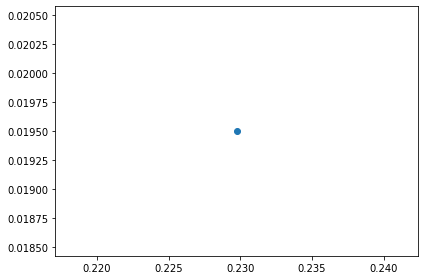

In [20]:
fig, ax = plt.subplots()
ax.scatter([tfidf_hv['matrimonio']], [tfidf_hv['lavoro']])
plt.tight_layout()
plt.show()

In [24]:
def doc_tfidf(pope, document):
    tf_count = db.document_term_count(pope, document)
    tf = tf_count / tf_count.max()
    tfidf_x = tfidf(tf, idf, min_idf=4)
    return tfidf_x

In [25]:
from collections import defaultdict

In [26]:
d1 = ('Paul VI', 'Humanae Vitae')
d2 = ('Leo XIII', 'Rerum Novarum')
d3 = ('Leo XIII', 'Caritatis')
cases = [d1, d2, d3]
index_docs = defaultdict(lambda: defaultdict(lambda: 0))
for pope, doc in cases:
    data_case = doc_tfidf(pope, doc)
    for word, tfidf_w in data_case.items():
        index_docs["{} {}".format(pope, doc)][word] = tfidf_w

In [27]:
dfr = pd.DataFrame(index_docs).fillna(0)

In [28]:
dfr.sort_values('Leo XIII Rerum Novarum', ascending=False)

,Paul VI Humanae Vitae,Leo XIII Rerum Novarum,Leo XIII Caritatis
operaio,0.000000,0.344368,0.027143
stato,0.019365,0.236363,0.139373
lavoro,0.019501,0.184127,0.043184
società,0.036108,0.166307,0.059970
proprietà,0.000000,0.156526,0.000000
...,...,...,...
assistere,0.032253,0.000000,0.000000
aborto,0.015328,0.000000,0.000000
pertinente,0.021989,0.000000,0.000000
consapevole,0.014014,0.000000,0.000000


In [29]:
dfr.T

,onesto,obiettare,genitore,eroico,avvenire,contrario,LETTERA,Inscindibili,ministro,trasmissione,...,dedicare,dedicare si,sentire si,edificare,assemblee,proprî,"2,1",riversare,orsono,contrada
Paul VI Humanae Vitae,0.096571,0.022637,0.040631,0.016488,0.011244,0.035232,0.013415,0.025111,0.012953,0.048766,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
Leo XIII Rerum Novarum,0.019062,0.000000,0.012476,0.000000,0.041430,0.032455,0.006179,0.000000,0.017898,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
Leo XIII Caritatis,0.000000,0.000000,0.014996,0.000000,0.037349,0.000000,0.014854,0.000000,0.000000,0.000000,...,0.014812,0.019161,0.018668,0.017104,0.024347,0.022951,0.02105,0.03848,0.027804,0.019878


In [30]:
dfr.loc[['matrimonio', 'lavoro']].T

,matrimonio,lavoro
Paul VI Humanae Vitae,0.229734,0.019501
Leo XIII Rerum Novarum,0.005569,0.184127
Leo XIII Caritatis,0.013388,0.043184


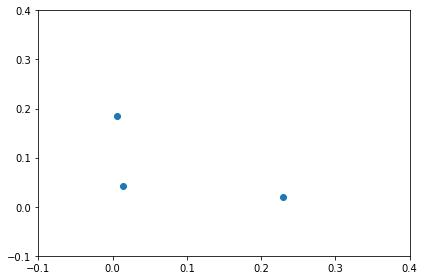

In [31]:
fig, ax = plt.subplots()
ax.scatter(dfr.T['matrimonio'], dfr.T['lavoro'])
ax.set_ylim(-.1, .4)
ax.set_xlim(-.1, .4)
plt.tight_layout()
plt.show()

## Vectors of words

In [32]:
words = dfr[['Leo XIII Rerum Novarum', 'Leo XIII Caritatis']]

In [33]:
words

,Leo XIII Rerum Novarum,Leo XIII Caritatis
onesto,0.019062,0.000000
obiettare,0.000000,0.000000
genitore,0.012476,0.014996
eroico,0.000000,0.000000
avvenire,0.041430,0.037349
...,...,...
proprî,0.000000,0.022951
"2,1",0.000000,0.021050
riversare,0.000000,0.038480
orsono,0.000000,0.027804


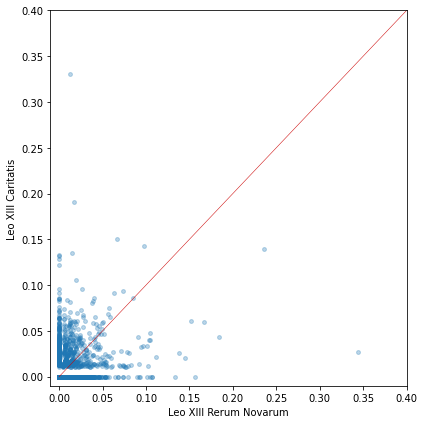

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(words.T.loc['Leo XIII Rerum Novarum'], 
           words.T.loc['Leo XIII Caritatis'], alpha=.3, s=15)
ax.plot([0, .4], [0, .4], c='#cc0000', linewidth=.5)
ax.set_ylim(-.01, .4)
ax.set_xlim(-.01, .4)
ax.set_xlabel('Leo XIII Rerum Novarum')
ax.set_ylabel('Leo XIII Caritatis')
plt.tight_layout()
plt.show()

$$
y = a x + b
$$

## Euclidean similarity

In [35]:
v1 = dfr['Paul VI Humanae Vitae'].values
v2 = dfr['Leo XIII Rerum Novarum'].values
v3 = dfr['Leo XIII Caritatis'].values

In [36]:
np.linalg.norm(v2 - v3)

1.3030388519631344

## Kullback–Leibler divergence

$$
KL(x) = P(x) \log\left(\frac{P(x)}{Q(x)}\right)
$$

In [37]:
freq_star = db.term_count()
freq_star_n = freq_star / freq_star.sum()

In [38]:
freq_star_n.sort_values(ascending=False)

,             7.092050e-02
il            5.931947e-02
e             3.351192e-02
di il         3.310505e-02
.             3.016209e-02
                  ...     
talium        5.930998e-07
landa         5.930998e-07
infonder      5.930998e-07
incorporee    5.930998e-07
Incapaci      5.930998e-07
Length: 43723, dtype: float64

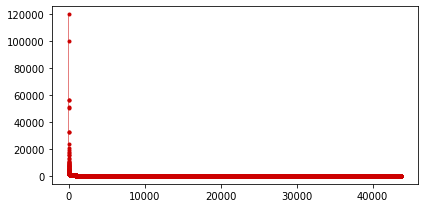

In [39]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(freq_star.sort_values(ascending=False).values, c='#cc0000', linewidth=.5, marker='.')
plt.tight_layout()
plt.show()

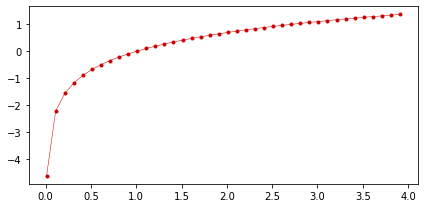

In [40]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(np.arange(0.01, 4, .1), np.log(np.arange(0.01, 4, .1)), c='#cc0000', linewidth=.5, marker='.')
plt.tight_layout()
plt.show()

In [41]:
freq_hv = db.term_count(m=VaticanMongoDb.generate_filter('Paul VI', 'Humanae Vitae'))
freq_hv_n = freq_hv / freq_hv.sum()

In [42]:
freq_hv_n.sort_values(ascending=False)

,               0.067611
il              0.061824
di il           0.044160
e               0.033501
di              0.030303
                  ...   
vivissimo       0.000152
perfezionare    0.000152
concordanza     0.000152
ordinamento     0.000152
risorsa         0.000152
Length: 1381, dtype: float64

In [43]:
word = 'laico'
print(freq_hv_n[word], freq_star_n[word], freq_hv_n[word] / freq_star_n[word])
print(np.log(freq_hv_n[word] / freq_star_n[word]))

0.00015227653418608191 0.00011802685199847929 1.2901855095486567
0.2547860138861823


In [44]:
vocabulary = freq_hv_n.index.values
kl_hv = freq_hv_n * np.log(freq_hv_n / freq_star_n[vocabulary])

In [45]:
kl_hv.sort_values(ascending=False).head(10)

coniugale      0.021541
sposo          0.015181
di il          0.012724
coniuge        0.009076
regolazione    0.008666
a il           0.007861
matrimonio     0.007541
atto           0.006759
natalità       0.006732
legge          0.006436
dtype: float64

## Co-occurrences

In [46]:
import nltk

In [47]:
sentences = db.get_sentences('Paul VI', 'Humanae Vitae', field='lemma')

### n-gram

In [48]:
from collections import defaultdict

In [50]:
s1 = VaticanMongoDb.to_words(sentence=sentences[12][:11])
example = " ".join(s1).lower()

In [51]:
print(example)
for bigram in nltk.ngrams(example.split(), n=2):
    print(bigram)

e come essere potere accadere che divenure noi padre di tutto
('e', 'come')
('come', 'essere')
('essere', 'potere')
('potere', 'accadere')
('accadere', 'che')
('che', 'divenure')
('divenure', 'noi')
('noi', 'padre')
('padre', 'di')
('di', 'tutto')


In [52]:
bigram_freq = defaultdict(lambda: 0)
for sentence in sentences:
    for bigram in nltk.ngrams([w['token'] for w in sentence], n=2):
        bigram_freq[bigram] += 1

In [53]:
unigram_freq = defaultdict(lambda: 0)
for sentence in sentences:
    for unigram in [w['token'] for w in sentence]:
        unigram_freq[unigram] += 1

In [54]:
bigrams = pd.Series(bigram_freq).sort_values(ascending=False)
bgrams_n = bigrams / bigrams.sum()
unigrams = pd.Series(unigram_freq).sort_values(ascending=False)
unigrams_n = unigrams / unigrams.sum()

$$
P(w_i, w_j), \ P(w)
$$

## Pointwise mutual information

$$
PMI(w_i, w_j) = P(w_i, w_j) \log\left(\frac{P(w_i, w_j)}{P(w_i)P(w_j)}\right)
$$

In [55]:
w1, w2 = 'il', 'matrimonio'
num = bgrams_n[(w1, w2)]
den = unigrams_n[w1]*unigrams_n[w2]
num * np.log(num / den)

6.598689506112792e-05

In [56]:
num / den

3.858440571267503

### Most relevant pairs

In [66]:
pmi_index = []
for (a, b), p_a_b in bgrams_n.items():
    p_a = unigrams_n[a]
    p_b = unigrams_n[b]
    pmi = p_a_b * np.log(p_a_b / (p_a * p_b))
    pmi_index.append({
        'word_a': a, 'word_b': b, 'pmi': pmi, 'count': bigrams[(a, b)],
        'count_a': unigrams[a], 'count_b': unigrams[b]
    })
pmi_index = pd.DataFrame(pmi_index)

In [69]:
pmi_index.sort_values('pmi', ascending=False).head(20)

,word_a,word_b,pmi,count,count_a,count_b
5,tutto,il,0.006881,4967,9303,100016
6,con,il,0.005757,4800,12141,100016
4,per,il,0.005528,5081,15389,100016
8,il,suo,0.004908,4069,100016,10182
10,",",ma,0.004719,3424,119576,5426
90,Venerabili,Fratelli,0.004132,898,918,1012
3,",",che,0.003989,6188,119576,32102
45,»,(,0.003768,1503,6599,6963
1,e,il,0.003625,7229,56503,100016
20,di il,chiesa,0.003459,2297,55817,6344


In [71]:
pmi_index[(pmi_index.count_a < 5000) & (pmi_index.count_b < 5000)].sort_values(
    'pmi', ascending=False).head(20)

,word_a,word_b,pmi,count,count_a,count_b
90,Venerabili,Fratelli,0.004132,898,918,1012
76,Gesù,Cristo,0.003342,1030,2068,4617
124,Spirito,Santo,0.003014,691,1268,830
433,Leone,XIII,0.001258,263,373,545
459,Sede,Apostolica,0.001175,253,427,573
487,venerabile,fratello,0.001130,241,280,774
339,bene,comune,0.001005,310,2917,989
617,concilio,Vaticano,0.000986,212,731,277
448,genere,umano,0.000875,255,558,3139
588,San,Pietro,0.000871,217,920,630
